In [ ]:
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

# Exploratory Data Analysis

In [2]:
# setting seaborn theme
sb.set_theme()

In [3]:
# reading in the datasets
training_data = pd.read_csv("customer_churn_dataset-training-master.csv")
test_data = pd.read_csv("customer_churn_dataset-testing-master.csv")

In [4]:
# inspecting shape of training data
training_data.shape

(440833, 12)

In [5]:
# creating nicer column headers
training_data.columns = [col.lower().replace(" ", "_") for col in  training_data.columns]
test_data.columns = training_data.columns

training_data.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [6]:
training_data.head()

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [7]:
data.dtypes

customerid            int64
age                   int64
gender               object
tenure                int64
usage_frequency       int64
support_calls         int64
payment_delay         int64
subscription_type    object
contract_length      object
total_spend           int64
last_interaction      int64
churn                 int64
dtype: object

In [7]:
# observing distribution of target variable
training_data.churn.value_counts()

1.0    249999
0.0    190833
Name: churn, dtype: int64

In [8]:
training_data.churn.value_counts()/training_data.shape[0]

1.0    0.567106
0.0    0.432892
Name: churn, dtype: float64

In [22]:
# dropping any rows with missing values
training_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# isolating target from input features
target = training_data.churn
features = training_data.iloc[:,1:-1] # removed customerid and churn

test_target = test_data.churn
test_features = test_data.iloc[:,1:-1] # removed customerid and churn

In [11]:
features.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0


## Visualizing Distributions of Input Features

In [15]:
features.dtypes

age                  float64
gender                object
tenure               float64
usage_frequency      float64
support_calls        float64
payment_delay        float64
subscription_type     object
contract_length       object
total_spend          float64
last_interaction     float64
dtype: object

In [21]:
features["subscription_type"].value_counts(dropna=False)

Standard    149128
Premium     148678
Basic       143026
NaN              1
Name: subscription_type, dtype: int64

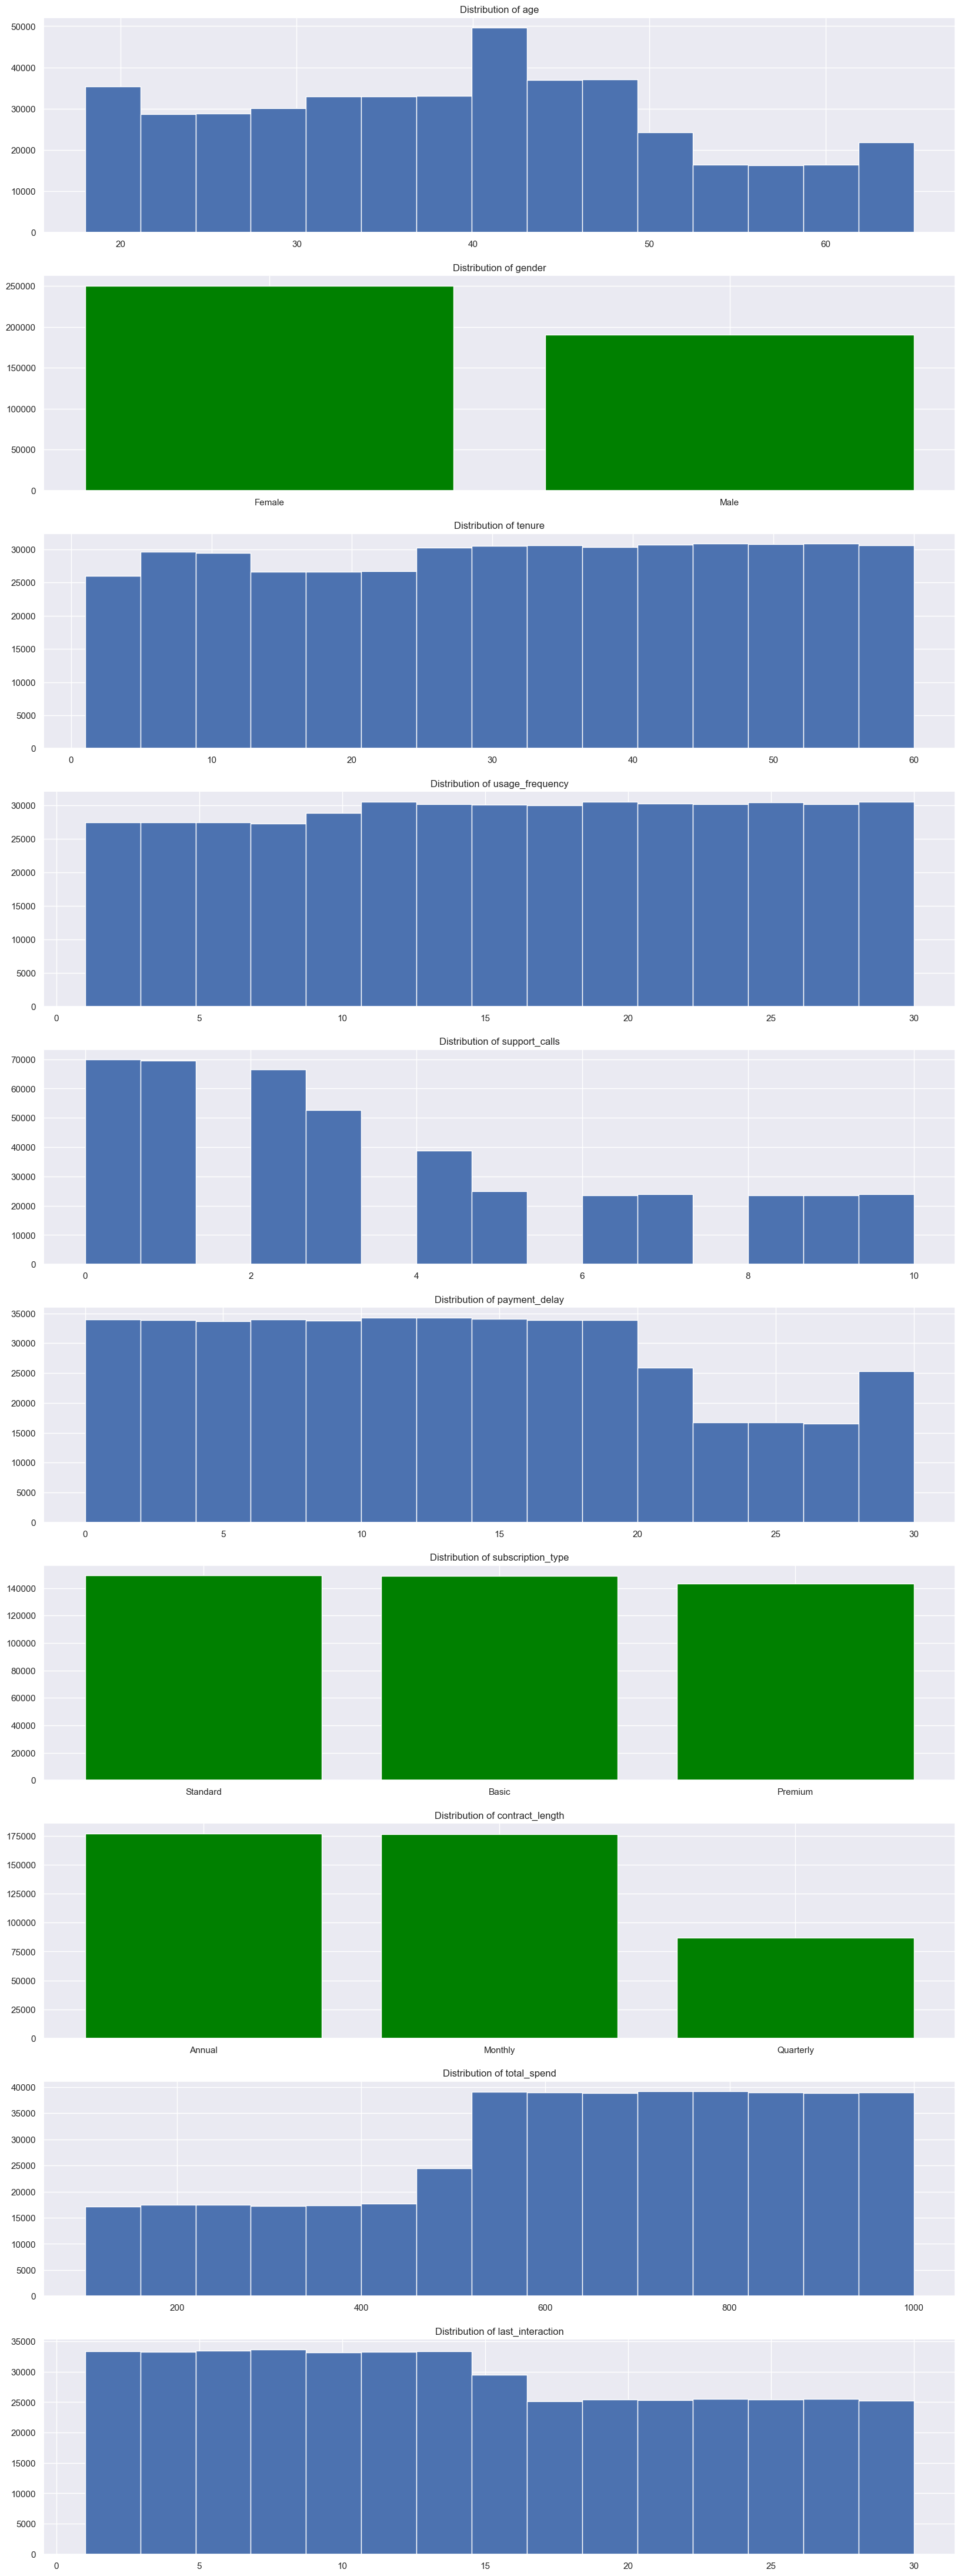

In [24]:
fig, ax = plt.subplots(features.shape[1], 1, figsize=(20, 56))

for i, feature in enumerate(features.columns):
    if features[feature].dtype != "object":
        ax[i].hist(features[feature], bins=15)
    else:
        ax[i].bar(features[feature].unique(),
                  features[feature].value_counts(), color="green")

    ax[i].set_title(f"Distribution of {feature}")

# Preprocessing

In [31]:
# encoding categorical features
es_features = features.copy()
es_test_features = test_features.copy()
label_encoders = []

for feature in es_features:
    if es_features[feature].dtype == "O":
        print(f"Encoding: {feature}")
        le = LabelEncoder()
        
		# fitting encoder on training data
        es_features[feature] = le.fit_transform(es_features[feature])
        
		# applying encoder to test data
        es_test_features[feature] = le.transform(es_test_features[feature])
        label_encoders.append(le)

# scaling numerical features
scaler = RobustScaler()

# fitting scaler on training data
es_features[features.dtypes[features.dtypes != "object"].index] = scaler.fit_transform(
    es_features[features.dtypes[features.dtypes != "object"].index])

# applying scaler to test data
es_test_features[features.dtypes[features.dtypes != "object"].index] = scaler.transform(
    es_test_features[features.dtypes[features.dtypes != "object"].index])

 

Encoding: gender
Encoding: subscription_type
Encoding: contract_length


In [26]:
es_features.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,-0.473684,0,0.233333,-0.142857,0.4,0.461538,2,0,0.774286,0.200000
1,1.368421,0,0.566667,-1.071429,1.4,-0.307692,0,1,-0.297143,-0.533333
2,0.842105,0,-0.600000,-0.857143,0.6,0.461538,0,2,-1.360000,-0.733333
3,1.000000,1,0.200000,0.357143,0.8,-0.384615,2,1,-0.757143,1.000000
4,-0.842105,1,0.000000,0.285714,0.4,-0.307692,0,1,-0.125714,0.400000


# Basic Modeling

In [47]:
# Fitting Random Forest Classifier
param_dist = {
    'n_estimators': stats.randint(10, 2000),
    'max_depth': stats.randint(1, 200),
    'min_samples_split': stats.randint(2, 10),
    'min_samples_leaf': stats.randint(1, 10)}

rfc = RandomForestClassifier(
    random_state=3, criterion='entropy', warm_start=True)

rand_search = RandomizedSearchCV(
    rfc, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1)

rand_search.fit(es_features, target)

print('Best hyperparameters:',  rand_search.best_params_)
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(es_test_features)

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters: {'max_depth': 105, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1428}


In [48]:
print(f"accuracy score: {metrics.accuracy_score(test_target, y_pred)}")
print(f"precision score: {metrics.precision_score(test_target, y_pred)}")
print(f"recall score: {metrics.recall_score(test_target, y_pred)}")
print(f"f1 score: {metrics.f1_score(test_target, y_pred)}")
print(f"roc auc score: {metrics.roc_auc_score(test_target, y_pred)}")

accuracy score: 0.5034485972597632
precision score: 0.4882005899705015
recall score: 0.9986554291148788
f1 score: 0.6558054894528852
roc auc score: 0.5282082080493671


In [46]:
metrics.confusion_matrix(test_target, y_pred)

array([[ 1967, 31914],
       [   44, 30449]])

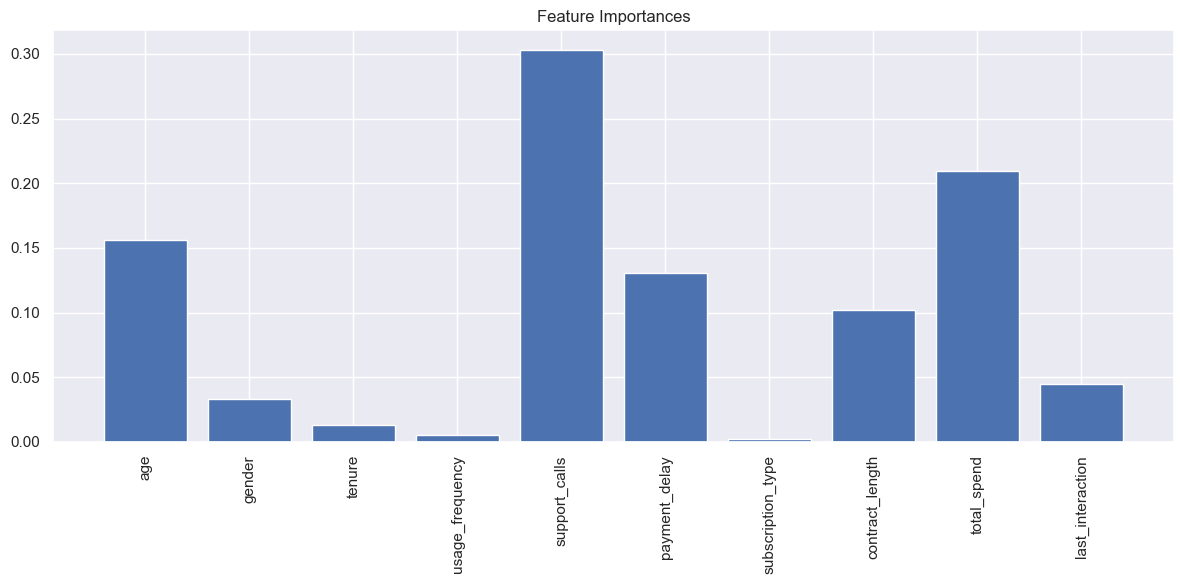

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(es_features.columns, best_rf.feature_importances_)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Feature Importances")

plt.tight_layout()
plt.show()